# importing & Set-up

- test different models in the ensembles (random forest, xgb etc)
- add linear model, lasso or ridge
- normalize the data 
- removing outliers
- target encoding based on cluster
- psuedo labeling
- encode the target nigga
- train without the engineered features
- train on subsets of data - like the first 1000
- cluster based on target

In [159]:
import pandas as pd                                    
import numpy as np     
from sklearn.utils.class_weight import compute_class_weight                  
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error         
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit, StratifiedGroupKFold,StratifiedKFold 
from sklearn.preprocessing import LabelEncoder         
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import f1_score,roc_auc_score, roc_curve, auc,log_loss
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sys, os, contextlib
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
@contextlib.contextmanager
def suppress_output(): 
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try: 
            yield
        finally: 
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
# Initialize models
lgbm_model = CatBoostClassifier(random_state=seed)
svm_model = SVC(probability=True, random_state=seed)
knn_model = KNeighborsClassifier()

class CFG:
  data_folder ="../data/"

def reading_data(path: str) -> pd.DataFrame:
  sample = pd.read_csv(path + "SampleSubmission.csv")
  train = pd.read_csv(path + 'Train.csv')
  test = pd.read_csv(path + 'Test.csv')
  return sample,train,test

sample,train,test = reading_data(CFG.data_folder)
sample_id = sample['id']
test_id = test['id']
train_id = train['id']

seed = 7 
tiney_fraction = 1e-05

#pd.options.display.max_columns = 200

train.fillna(method='ffill',inplace=True)
test.fillna(method='ffill',inplace=True)

misslead = [2, 12, 29, 31, 38, 77, 81, 97, 102, 115, 116, 130, 131, 133, 136, 143,
            146, 150, 153, 171, 180, 220, 221, 225, 231, 233, 244, 249, 270, 271, 274,
            283, 303, 343, 355, 396, 409, 417, 424, 435, 467, 470, 492, 495, 496, 515, 
            545, 551, 560, 579, 585, 586, 589, 592, 598, 611, 617, 636, 654, 656, 664, 683,
            688, 718, 721, 726, 754, 784, 788, 806, 812, 842, 855, 857, 862, 894, 900, 904,
            924, 947, 960, 980, 994, 1011, 1012, 1017, 1020, 1023, 1024, 1025, 1034, 1040, 
            1045, 1057, 1061, 1081, 1086, 1121, 1122, 1138, 1151, 1156, 1178, 1207, 1211, 1224, 
            1240, 1243, 1246, 1255, 1262, 1267, 1286, 1302, 1315, 1334, 1336, 1358, 1366, 1367,
            1392, 1405, 1427, 1461, 1465, 1474, 1504, 1513, 1517, 1521, 1522, 1530, 1534, 1585, 
            1587, 1604, 1608, 1614, 1615, 1619, 1625, 1646, 1649, 1652, 1656, 1657, 1665, 1674,
            1677, 1708, 1736, 1740, 1795, 1800, 1803, 1807, 1810, 1831, 1845, 1851, 1861, 1869,
            1876, 1877, 1886, 1893, 1898, 1900, 1930, 1953, 1954, 1967, 1994, 1999, 2020, 
            2029, 2034, 2050, 2055, 2056, 2065, 2066, 2086, 2095, 2105, 2120, 2122]

#train = train.drop(index=misslead).reset_index(drop=True)
#test = test.drop(index=misslead).reset_index(drop=True)


/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/2991291706.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill',inplace=True)
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/2991291706.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill',inplace=True)


In [145]:
#setup clusters 
kmeans = KMeans(n_clusters=2)

lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 6
num_clusters_lon = 6
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = ((row['LAT2'] - lat_min) / lat_step)
    lon_cluster = ((row['LON1'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min)

In [146]:
geospatial_columns = ['LAT2', 'LON1', 'ELEV1', 'PEND1']
geo_train_data = train[geospatial_columns]
geo_test_data = test[geospatial_columns]
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
train['Spatial_Group'] = kmeans.fit_predict(geo_train_data)
test['Spatial_Group'] = kmeans.predict(geo_test_data)

In [147]:

train['day_of_year'] = np.random.randint(1, 366, size=len(train))  # random day of the year
test['day_of_year'] = np.random.randint(1, 366, size=len(test))

days_in_month = {
    1: (1, 31),    # January
    2: (32, 59),   # February
    3: (60, 90),   # March
    4: (91, 120),  # April
    5: (121, 151), # May
    6: (152, 181), # June
    7: (182, 212), # July
    8: (213, 243), # August
    9: (244, 273), # September
    10: (274, 304),# October
    11: (305, 334),# November
    12: (335, 365) # December
}

# Function to map 'day_of_year' to 'month'
def map_day_to_month(day_of_year):
    for month, (start_day, end_day) in days_in_month.items():
        if start_day <= day_of_year <= end_day:
            return month
    return None  # Just in case, although the logic should cover all days

# Loop over both train and test datasets to add the month feature
for df in (train, test):
    df['month'] = df['day_of_year'].apply(map_day_to_month)

# Check results
print(train.head())
print(test.head())

              id  REFLEC1  REFLEC2  REFLEC3  REFLEC4  REFLEC5  REFLEC6  \
0  id_0taivml7ol    231.0    251.0    496.0    464.0   2557.0   2035.0   
1  id_croxu0xdq9    345.0    402.0    805.0    805.0   2997.0   2443.0   
2  id_qfv0klgl9b    413.0    518.0    775.0   1022.0   2936.0   3266.0   
3  id_mlubcnl27r    196.0    295.0    806.0    675.0   2964.0   2249.0   
4  id_rej7e1nz2p    366.0    404.0    697.0    803.0   2479.0   2722.0   

   REFLEC7         PCA1         PCA2  ...      VHD1    VHVVD1    MNDWI1  \
0   1051.0  15578.91895   672.583374  ...  0.036469  0.250200 -0.608060   
1   1434.0  16403.79688   900.683044  ...  0.035914  0.275557 -0.504310   
2   2351.0  17203.26953  1275.056519  ...  0.007986  0.193860 -0.616432   
3   1260.0  16105.81738   900.010620  ...  0.008118  0.116911 -0.472340   
4   1794.0  16414.72266   822.154480  ...  0.022265  0.213336 -0.592278   

      NDTI1  Target  lat_cluster  lon_cluster  Spatial_Group  day_of_year  \
0  0.318859      80  -153.1

# validation

In [148]:
"""def drop_features(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]: 
    train_dropped = train.drop(columns=['VHVVD1','lat_cluster', 'Spatial_Group', 'id', 'lon_cluster'], inplace=False)
    test_dropped = test.drop(columns=['VHVVD1','lat_cluster', 'Spatial_Group', 'id', 'lon_cluster'], inplace=False)
    
    return train_dropped, test_dropped

train, test = drop_features(train, test)
"""

"def drop_features(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]: \n    train_dropped = train.drop(columns=['VHVVD1','lat_cluster', 'Spatial_Group', 'id', 'lon_cluster'], inplace=False)\n    test_dropped = test.drop(columns=['VHVVD1','lat_cluster', 'Spatial_Group', 'id', 'lon_cluster'], inplace=False)\n    \n    return train_dropped, test_dropped\n\ntrain, test = drop_features(train, test)\n"

In [149]:
"""train = train[train['NDVI2'] < 0.88]
train = train[train['NDVI1'] < 0.85]
train = train[train['NDVI3'] < 0.95]
train = train[train['ELEV1'] < 2400]
train = train[train['VHVVR1'] < 0.400000]"""

"train = train[train['NDVI2'] < 0.88]\ntrain = train[train['NDVI1'] < 0.85]\ntrain = train[train['NDVI3'] < 0.95]\ntrain = train[train['ELEV1'] < 2400]\ntrain = train[train['VHVVR1'] < 0.400000]"

In [150]:

train_id = train['id']
predictive_features = ['Spatial_Group','lon_cluster','lat_cluster','NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PRECIPAN1', 'TMPMAX1', 'TMPMIN1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1','Target']
for df in (train,test):
    for col in df.columns: 
        if col not in predictive_features:
            df.drop(columns=[col],inplace=True)

Target = train['Target']
scaler = StandardScaler()
train_columns = train.drop(columns='Target').columns
test_columns = test.columns
train_scaled = scaler.fit_transform(train.drop(columns='Target'))
train = pd.DataFrame(train_scaled, columns=train_columns)
train['Target'] = Target
test_scaled = scaler.transform(test)
test = pd.DataFrame(test_scaled, columns=test_columns)

In [151]:
train = train.fillna(method='bfill')
test = test.fillna(method='bfill')

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/610108685.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='bfill')
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/610108685.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='bfill')


In [152]:
suspected_incorrect_labels = []
confidence_threshold = 0.8  

def fit_and_predict(train_data, train_target, test_data):
    lgbm_model.fit(train_data, train_target)  
    y_pred_lgbm = lgbm_model.predict_proba(test_data) 
    return y_pred_lgbm  


def detect_and_remove_mislabeled(train_data, train_target):
    global suspected_incorrect_labels
    y_pred_train = fit_and_predict(train_data, train_target, train_data) 
    for i, (true_label, pred_probs) in enumerate(zip(train_target, y_pred_train)):
        predicted_class = np.argmax(pred_probs)
        predicted_prob = pred_probs[predicted_class]
        
        if predicted_class != true_label and predicted_prob >= confidence_threshold:
            suspected_incorrect_labels.append(i)
    class_distribution = train_target.value_counts()
    remove_indices = []
    for idx in suspected_incorrect_labels:
        sample_class = train_target.iloc[idx]
        if class_distribution[sample_class] > 1:  
            remove_indices.append(idx)
            class_distribution[sample_class] -= 1  
    train_data_cleaned = train_data.drop(index=remove_indices)
    train_target_cleaned = train_target.drop(index=remove_indices)
    
    return train_data_cleaned, train_target_cleaned, remove_indices
train_cleaned, target_cleaned, removed_indices = detect_and_remove_mislabeled(train.drop(columns='Target'), train['Target'])
print("Remaining class distribution after removal:")
print(target_cleaned.value_counts())
print("\nIndices of removed samples:", removed_indices)
y_pred_cleaned = fit_and_predict(train_cleaned, target_cleaned, test)
y_pred_cleaned = np.round(y_pred_cleaned, 1)
mask = y_pred_cleaned >= 0.9
y_pred_cleaned[~mask] = 0
class_labels = [f"Target{i}" for i in range(y_pred_cleaned.shape[1])]
sub_df = pd.DataFrame(y_pred_cleaned, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]
all_target_labels = [f"Target_{i}" for i in range(125)]  # Adjust target classes accordingly
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0
value = np.array(scores).mean()
 sub_df.to_csv(f"../submissions/submission{value:.4f}.csv", index=False)

Learning rate set to 0.082224
0:	learn: 3.7591727	total: 61.4ms	remaining: 1m 1s
1:	learn: 3.7150067	total: 129ms	remaining: 1m 4s
2:	learn: 3.6715535	total: 180ms	remaining: 60s
3:	learn: 3.6302800	total: 232ms	remaining: 57.9s
4:	learn: 3.5930537	total: 288ms	remaining: 57.2s
5:	learn: 3.5587807	total: 354ms	remaining: 58.7s
6:	learn: 3.5265587	total: 413ms	remaining: 58.5s
7:	learn: 3.4909434	total: 464ms	remaining: 57.5s
8:	learn: 3.4628315	total: 512ms	remaining: 56.4s
9:	learn: 3.4323328	total: 564ms	remaining: 55.9s
10:	learn: 3.4039407	total: 619ms	remaining: 55.6s
11:	learn: 3.3775036	total: 671ms	remaining: 55.2s
12:	learn: 3.3521980	total: 749ms	remaining: 56.9s
13:	learn: 3.3300924	total: 816ms	remaining: 57.5s
14:	learn: 3.3066377	total: 920ms	remaining: 1m
15:	learn: 3.2850254	total: 996ms	remaining: 1m 1s
16:	learn: 3.2643708	total: 1.07s	remaining: 1m 2s
17:	learn: 3.2435297	total: 1.13s	remaining: 1m 1s
18:	learn: 3.2234623	total: 1.18s	remaining: 1m 1s
19:	learn: 3.20

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/3911266326.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/3911266326.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/3911266326.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [155]:
#sub_df.to_csv(f"../submissions/submission_revide.csv", index=False)

In [154]:
suspected_incorrect_labels

[2,
 12,
 29,
 31,
 38,
 77,
 81,
 97,
 102,
 115,
 116,
 130,
 131,
 133,
 136,
 143,
 146,
 150,
 153,
 171,
 180,
 220,
 221,
 225,
 231,
 233,
 244,
 249,
 270,
 271,
 274,
 283,
 303,
 343,
 355,
 396,
 409,
 417,
 424,
 435,
 467,
 470,
 492,
 495,
 496,
 515,
 545,
 551,
 560,
 579,
 585,
 586,
 589,
 592,
 598,
 611,
 617,
 636,
 654,
 656,
 664,
 683,
 688,
 718,
 721,
 726,
 754,
 784,
 788,
 806,
 812,
 842,
 855,
 857,
 862,
 894,
 900,
 904,
 924,
 947,
 960,
 980,
 994,
 1011,
 1012,
 1017,
 1020,
 1023,
 1024,
 1025,
 1034,
 1040,
 1045,
 1057,
 1061,
 1081,
 1086,
 1121,
 1122,
 1138,
 1151,
 1156,
 1178,
 1207,
 1211,
 1224,
 1240,
 1243,
 1246,
 1255,
 1262,
 1267,
 1286,
 1302,
 1315,
 1334,
 1336,
 1358,
 1366,
 1367,
 1392,
 1405,
 1427,
 1461,
 1465,
 1474,
 1504,
 1513,
 1517,
 1521,
 1522,
 1530,
 1534,
 1585,
 1587,
 1604,
 1608,
 1614,
 1615,
 1619,
 1625,
 1646,
 1649,
 1652,
 1656,
 1657,
 1665,
 1674,
 1677,
 1708,
 1736,
 1740,
 1795,
 1800,
 1803,
 1807,


In [109]:
"""import numpy as np
import pandas as pd

# Initialize the list to store indices of suspected mislabeled samples
suspected_incorrect_labels = []

# Define a threshold to detect suspicious labels (tune this based on your data)
confidence_threshold = 0.8  # if the model is very confident (e.g., > 80%) but wrong

# Function to fit LightGBM model and make predictions (probabilities)
def fit_and_predict(train_data, train_target, test_data):
    with suppress_output():
        # Train LightGBM model
        lgbm_model.fit(train_data, train_target)
    
    # Get predictions (probabilities) from LightGBM model
    y_pred_lgbm = lgbm_model.predict_proba(test_data)
    
    return y_pred_lgbm  # Only return predictions from the LightGBM model

# Function to identify and remove misclassified samples based on predicted probabilities
def detect_and_remove_mislabeled(train_data, train_target):
    global suspected_incorrect_labels
    y_pred_train = fit_and_predict(train_data, train_target, train_data)  # Predict on training data
    
    # Iterate over the training set to detect suspicious labels
    for i, (true_label, pred_probs) in enumerate(zip(train_target, y_pred_train)):
        # Get predicted class with highest probability
        predicted_class = np.argmax(pred_probs)
        predicted_prob = pred_probs[predicted_class]
        
        # If the true label does not match the predicted class and the model is confident, mark it as suspicious
        if predicted_class != true_label and predicted_prob >= confidence_threshold:
            suspected_incorrect_labels.append(i)

    # Remove the suspicious rows from the training data
    train_data_cleaned = train_data.drop(index=suspected_incorrect_labels)
    train_target_cleaned = train_target.drop(index=suspected_incorrect_labels)
    
    return train_data_cleaned, train_target_cleaned

# Detect and remove misclassified samples
train_cleaned, target_cleaned = detect_and_remove_mislabeled(train.drop(columns='Target'), train['Target'])

# Fit the final LightGBM model using the cleaned training data and predict on test data
y_pred_cleaned = fit_and_predict(train_cleaned, target_cleaned, test)

# Apply threshold and rounding for test predictions
y_pred_cleaned = np.round(y_pred_cleaned, 1)
mask = y_pred_cleaned >= 0.9
y_pred_cleaned[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred_cleaned.shape[1])]
sub_df = pd.DataFrame(y_pred_cleaned, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns if necessary
all_target_labels = [f"Target_{i}" for i in range(125)]  # Adjust target classes accordingly
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0

# Save the submission file
value = np.array(scores).mean()
sub_df.to_csv(f"../submissions/submission.csv", index=False)

# Output the indices of suspected incorrect labels
print("Suspected incorrect labels at indices:", suspected_incorrect_labels)
"""

'import numpy as np\nimport pandas as pd\n\n# Initialize the list to store indices of suspected mislabeled samples\nsuspected_incorrect_labels = []\n\n# Define a threshold to detect suspicious labels (tune this based on your data)\nconfidence_threshold = 0.8  # if the model is very confident (e.g., > 80%) but wrong\n\n# Function to fit LightGBM model and make predictions (probabilities)\ndef fit_and_predict(train_data, train_target, test_data):\n    with suppress_output():\n        # Train LightGBM model\n        lgbm_model.fit(train_data, train_target)\n    \n    # Get predictions (probabilities) from LightGBM model\n    y_pred_lgbm = lgbm_model.predict_proba(test_data)\n    \n    return y_pred_lgbm  # Only return predictions from the LightGBM model\n\n# Function to identify and remove misclassified samples based on predicted probabilities\ndef detect_and_remove_mislabeled(train_data, train_target):\n    global suspected_incorrect_labels\n    y_pred_train = fit_and_predict(train_data,

In [50]:
"""# Calculate class weights based on the training data
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train['Target'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
# Initialize models with class weights (for models that support it)
lgbm_model = LGBMClassifier(random_state=seed, class_weight='balanced')  # Automatically adjust class weights
svm_model = SVC(probability=True, random_state=seed, class_weight='balanced')  # Same for SVM
knn_model = KNeighborsClassifier()  # KNN does not have class_weight, so we will adjust probabilities manually

# Function to train models and calculate log loss using class-weighted predictions
def validate(trainset, testset, target_col, unique_classes):
    with suppress_output():
        # Train models with automatic class weighting
        lgbm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
        svm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
        knn_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(testset.drop(columns=[target_col]))
    y_pred_svm = svm_model.predict_proba(testset.drop(columns=[target_col]))
    y_pred_knn = knn_model.predict_proba(testset.drop(columns=[target_col]))
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    # Adjust probabilities based on class weights for KNN model (since it doesn't support class weights directly)
    for class_index in range(len(unique_classes)):
        y_pred_weighted[:, class_index] *= class_weights_dict[class_index]
    
    # Normalize probabilities so they sum to 1
    y_pred_weighted /= y_pred_weighted.sum(axis=1, keepdims=True)

    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_pred_weighted[valid_idx]
    
    # Calculate log loss
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    print(f"Log Loss: {score}")
    return score

# Encoding target if it's categorical
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])

unique_classes = np.sort(train['Target'].unique())  # Extract all unique classes from the dataset

scores = []
for train_index, test_index in gkf.split(train.drop(columns='Target'), train['Target'], train_id):  # Group by spatial groups
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    score = validate(trainset=train_v, testset=test_v, target_col='Target', unique_classes=unique_classes)
    scores.append(score)

print(f'Mean Log Loss: {np.mean(scores)}')"""

'# Calculate class weights based on the training data\nclass_weights = compute_class_weight(class_weight=\'balanced\', classes=unique_classes, y=train[\'Target\'])\nclass_weights_dict = {i: weight for i, weight in enumerate(class_weights)}\n# Initialize models with class weights (for models that support it)\nlgbm_model = LGBMClassifier(random_state=seed, class_weight=\'balanced\')  # Automatically adjust class weights\nsvm_model = SVC(probability=True, random_state=seed, class_weight=\'balanced\')  # Same for SVM\nknn_model = KNeighborsClassifier()  # KNN does not have class_weight, so we will adjust probabilities manually\n\n# Function to train models and calculate log loss using class-weighted predictions\ndef validate(trainset, testset, target_col, unique_classes):\n    with suppress_output():\n        # Train models with automatic class weighting\n        lgbm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])\n        svm_model.fit(trainset.drop(columns=[target_c

In [51]:

# Weights for the models
model_weights = {'lgbm': 0.3, 'svm': 0.5, 'knn': 0.2}  # Adjust weights as needed

# Function to train models and calculate log loss using a weighted average
def validate(trainset, testset, target_col, unique_classes):
    with suppress_output():
        # Train models
        lgbm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
        svm_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
        knn_model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(testset.drop(columns=[target_col]))
    y_pred_svm = svm_model.predict_proba(testset.drop(columns=[target_col]))
    y_pred_knn = knn_model.predict_proba(testset.drop(columns=[target_col]))
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_pred_weighted[valid_idx]
    
    # Calculate log loss
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    print(f"Log Loss: {score}")
    return score

# Encoding target if it's categorical
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])

unique_classes = np.sort(train['Target'].unique())  # Extract all unique classes from the dataset

scores = []
for train_index, test_index in gkf.split(train.drop(columns='Target'), train['Target'], train_id):  # Group by spatial groups
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    score = validate(trainset=train_v, testset=test_v, target_col='Target', unique_classes=unique_classes)
    scores.append(score)

print(f'Mean Log Loss: {np.mean(scores)}')

/Users/ahmed/Downloads/computerscience/AI-Compeitions/INEGI-GCIM/vegitiables/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Log Loss: 3.3936637324992476
Log Loss: 3.448073534026593
Log Loss: 3.5127030053421495
Log Loss: 3.4900462971938047
Log Loss: 3.4303135763976496
Mean Log Loss: 3.4549600290918887


In [52]:
stop
#3.7070480050778643 lb = 5.135798437
#3.5039865977860694 = sameasabove
#3.506519503718497 removed the features

NameError: name 'stop' is not defined

# Adversarial Validation 

[LightGBM] [Info] Number of positive: 1698, number of negative: 738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9509
[LightGBM] [Info] Number of data points in the train set: 2436, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697044 -> initscore=0.833263
[LightGBM] [Info] Start training from score 0.833263
[LightGBM] [Info] Number of positive: 1698, number of negative: 739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9513
[LightGBM] [Info] Number of data points in the train set: 2437, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696758 -> initscore=0.831908
[LightGBM] [Info] Start training from score 0.831908
[LightGBM] [Info] Number

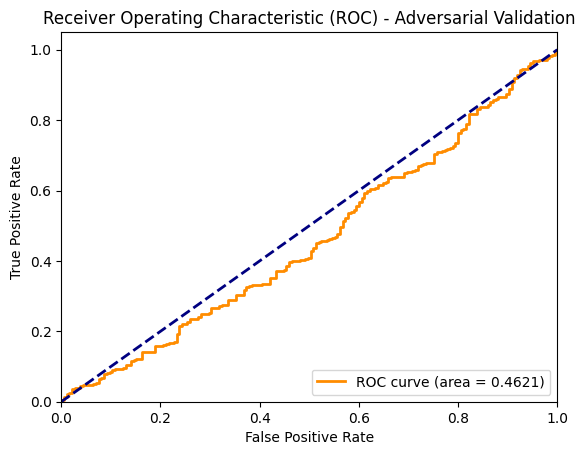

Mean Adversarial Validation ROC AUC: 0.4919


In [317]:
"""train['is_train'] = 1
test['is_train'] = 0
combined_data = pd.concat([train.drop(columns=['Target']), test], axis=0)

combined_target = combined_data['is_train']
combined_data = combined_data.drop(columns=['is_train'])

adversarial_splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
adversarial_model = LGBMClassifier(random_state=seed)

adversarial_scores = []

# Prepare to plot the ROC curve using the last split
for train_idx, test_idx in adversarial_splits.split(combined_data, combined_target):
    adv_train_data = combined_data.iloc[train_idx]
    adv_test_data = combined_data.iloc[test_idx]
    
    adv_train_target = combined_target.iloc[train_idx]
    adv_test_target = combined_target.iloc[test_idx]
    
    adversarial_model.fit(adv_train_data, adv_train_target)
    
    adv_pred = adversarial_model.predict_proba(adv_test_data)[:, 1]
    roc_auc = roc_auc_score(adv_test_target, adv_pred)
    adversarial_scores.append(roc_auc)

    # Compute ROC curve for the last split to plot
    fpr, tpr, _ = roc_curve(adv_test_target, adv_pred)
    roc_auc_plot = auc(fpr, tpr)

# Plot ROC curve for the last split
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_plot:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Adversarial Validation')
plt.legend(loc='lower right')
plt.show()

mean_adversarial_score = np.mean(adversarial_scores)

print(f'Mean Adversarial Validation ROC AUC: {mean_adversarial_score:.4f}')"""

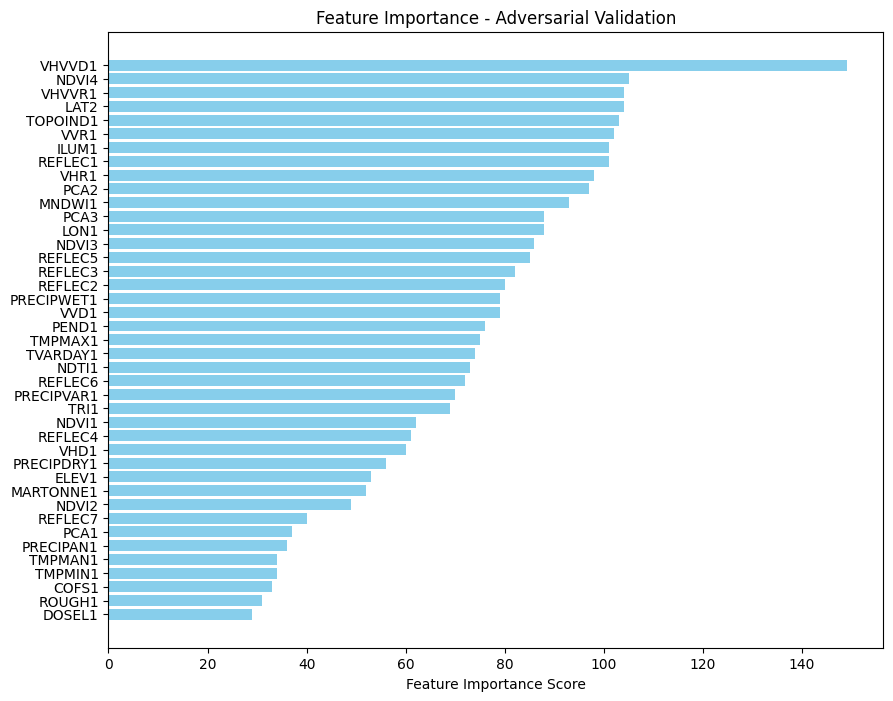

In [318]:
"""
# Plot Feature Importance
plt.figure(figsize=(10, 8))
importance = adversarial_model.feature_importances_
sorted_idx = np.argsort(importance)

plt.barh(combined_data.columns[sorted_idx], importance[sorted_idx], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance - Adversarial Validation')
plt.show()"""

# Semi-Supervised- Learning 

# inference

In [62]:
np.array(scores).mean()

np.float64(3.5757001015599825)

In [29]:

# Weights for the models
model_weights = {'lgbm': 0.4, 'svm': 0.4, 'knn': 0.2}  # Adjust weights as needed

# Training final ensemble on the whole train set and predicting for the test set
def fit_and_predict(train_data, train_target, test_data):
    with suppress_output():
        # Train models
        lgbm_model.fit(train_data, train_target)
        svm_model.fit(train_data, train_target)
        knn_model.fit(train_data, train_target)
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(test_data)
    y_pred_svm = svm_model.predict_proba(test_data)
    y_pred_knn = knn_model.predict_proba(test_data)
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    return y_pred_weighted

value = np.array(scores).mean()

# Fit the final model using the whole training data
y_pred = fit_and_predict(train.drop(columns='Target'), train['Target'], test)

# Apply threshold and rounding
y_pred = np.round(y_pred, 1)
mask = y_pred >= 0.9
y_pred[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns if necessary
all_target_labels = [f"Target_{i}" for i in range(125)]  # Up to Target_124
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  

# Save the submission file
sub_df.to_csv(f"../submissions/submission{value:.4f}.csv", index=False)


/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/1681712015.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/1681712015.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/1681712015.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [34]:
train.shape

(2123, 18)

# inference for weighted class

In [156]:

model_weights = {'lgbm': 0.4, 'svm': 0.4, 'knn': 0.2}  # Adjust weights as needed

# Function to fit models and make predictions (probabilities)
def fit_and_predict(train_data, train_target, test_data):
    # Train models
    lgbm_model.fit(train_data, train_target)
    svm_model.fit(train_data, train_target)
    knn_model.fit(train_data, train_target)
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(test_data)
    y_pred_svm = svm_model.predict_proba(test_data)
    y_pred_knn = knn_model.predict_proba(test_data)
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    return y_pred_weighted

# Function to remove mislabeled samples before training the models
def remove_mislabeled_samples(train_data, train_target, incorrect_indices):
    # Drop the mislabeled samples based on their indices
    train_data_cleaned = train_data.drop(index=incorrect_indices)
    train_target_cleaned = train_target.drop(index=incorrect_indices)
    
    return train_data_cleaned, train_target_cleaned

# Remove mislabeled samples from the training data
train_data_cleaned, train_target_cleaned = remove_mislabeled_samples(train.drop(columns='Target'), train['Target'], suspected_incorrect_labels)

# Train the ensemble models on the cleaned data and make predictions on the test data
y_pred_cleaned = fit_and_predict(train_data_cleaned, train_target_cleaned, test)

# Apply threshold and rounding
y_pred_cleaned = np.round(y_pred_cleaned, 1)
mask = y_pred_cleaned >= 0.9
y_pred_cleaned[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred_cleaned.shape[1])]
sub_df = pd.DataFrame(y_pred_cleaned, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns if necessary
all_target_labels = [f"Target_{i}" for i in range(125)]  # Adjust target classes accordingly
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0

# Save the submission file
value = np.array(scores).mean()
sub_df.to_csv(f"../submissions/submissionr.csv", index=False)

# Output the indices of suspected mislabeled samples
print("Suspected incorrect labels at indices:", suspected_incorrect_labels)


Learning rate set to 0.081838
0:	learn: 3.7605494	total: 169ms	remaining: 2m 48s
1:	learn: 3.7185543	total: 328ms	remaining: 2m 43s
2:	learn: 3.6705844	total: 401ms	remaining: 2m 13s
3:	learn: 3.6325782	total: 484ms	remaining: 2m
4:	learn: 3.5967820	total: 586ms	remaining: 1m 56s
5:	learn: 3.5632550	total: 680ms	remaining: 1m 52s
6:	learn: 3.5295685	total: 766ms	remaining: 1m 48s
7:	learn: 3.4970997	total: 856ms	remaining: 1m 46s
8:	learn: 3.4663312	total: 944ms	remaining: 1m 43s
9:	learn: 3.4387483	total: 1.02s	remaining: 1m 41s
10:	learn: 3.4135513	total: 1.11s	remaining: 1m 40s
11:	learn: 3.3883263	total: 1.2s	remaining: 1m 39s
12:	learn: 3.3644411	total: 1.29s	remaining: 1m 38s
13:	learn: 3.3398773	total: 1.38s	remaining: 1m 36s
14:	learn: 3.3175189	total: 1.47s	remaining: 1m 36s
15:	learn: 3.2943070	total: 1.56s	remaining: 1m 35s
16:	learn: 3.2742114	total: 1.65s	remaining: 1m 35s
17:	learn: 3.2550822	total: 1.75s	remaining: 1m 35s
18:	learn: 3.2336501	total: 1.88s	remaining: 1m 3

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/3440174449.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/3440174449.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_26716/3440174449.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [50]:
# Initialize models
lgbm_model = LGBMClassifier(random_state=seed, class_weight='balanced')
svm_model = SVC(probability=True, random_state=seed, class_weight='balanced')
knn_model = KNeighborsClassifier()

# Model weights for ensembling
model_weights = {'lgbm': 0.5, 'svm': 0.3, 'knn': 0.2}

# Function to train models and get predictions for test data
def fit_and_predict(train_data, train_target, test_data):
    with suppress_output():
        # Train models
        lgbm_model.fit(train_data, train_target)
        svm_model.fit(train_data, train_target)
        knn_model.fit(train_data, train_target)
    
    # Get predictions (probabilities) for each model
    y_pred_lgbm = lgbm_model.predict_proba(test_data)
    y_pred_svm = svm_model.predict_proba(test_data)
    y_pred_knn = knn_model.predict_proba(test_data)
    
    # Weighted average of predictions
    y_pred_weighted = (model_weights['lgbm'] * y_pred_lgbm +
                       model_weights['svm'] * y_pred_svm +
                       model_weights['knn'] * y_pred_knn)
    
    return y_pred_weighted

# Encode target if necessary
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])


value = np.mean(scores)

# Final model training and prediction for submission
y_pred = fit_and_predict(train.drop(columns='Target'), train['Target'], test)

# Apply threshold and rounding
y_pred = np.round(y_pred, 1)
mask = y_pred >= 0.9
y_pred[~mask] = 0

# Create the submission DataFrame
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

# Add missing columns (if any)
all_target_labels = [f"Target_{i}" for i in range(125)]  # Up to Target_124
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  # Add missing targets and fill with 0

# Save the submission file
sub_df.to_csv(f"../submissions/submission{value:.4f}.csv", index=False)

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/3905899454.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0  # Add missing targets and fill with 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/3905899454.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0  # Add missing targets and fill with 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/3905899454.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [ ]:
stop

In [333]:
train.columns

Index(['REFLEC1', 'REFLEC2', 'REFLEC3', 'REFLEC4', 'REFLEC5', 'REFLEC6',
       'REFLEC7', 'PCA1', 'PCA2', 'PCA3', 'NDVI1', 'NDVI2', 'NDVI3', 'NDVI4',
       'ELEV1', 'PEND1', 'ILUM1', 'TOPOIND1', 'ROUGH1', 'TRI1', 'COFS1',
       'TMPMAN1', 'TMPMAX1', 'TMPMIN1', 'TVARDAY1', 'PRECIPAN1', 'PRECIPWET1',
       'PRECIPDRY1', 'PRECIPVAR1', 'MARTONNE1', 'LAT2', 'LON1', 'DOSEL1',
       'VVR1', 'VHR1', 'VHVVR1', 'VVD1', 'VHD1', 'MNDWI1', 'NDTI1', 'Target'],
      dtype='object')

In [29]:
value  = np.array(scores).mean()
model.fit(train.drop(columns='Target'),train['Target'])
y_pred = model.predict_proba(test)
y_pred = np.round(y_pred,1)
mask = y_pred >= 0.1
y_pred[~mask] = 0
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]

all_target_labels = [f"Target_{i}" for i in range(125)]  # Up to Target_124
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0  
#sub_df = pd.DataFrame({'id': test_id,'Target':y_pred})
sub_df.to_csv(f"../submissions/submission{value}.csv", index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9764
[LightGBM] [Info] Number of data points in the train set: 2123, number of used features: 43
[LightGBM] [Info] Start training from score -3.303877
[LightGBM] [Info] Start training from score -6.274291
[LightGBM] [Info] Start training from score -4.770214
[LightGBM] [Info] Start training from score -4.569543
[LightGBM] [Info] Start training from score -5.021528
[LightGBM] [Info] Start training from score -3.470931
[LightGBM] [Info] Start training from score -4.134225
[LightGBM] [Info] Start training from score -6.274291
[LightGBM] [Info] Start training from score -3.291138
[LightGBM] [Info] Start training from score -3.853923
[LightGBM] [Info] Start training from score -6.274291
[LightGBM] [Info] Start training from score -3.171949


/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/984217964.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/984217964.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_44793/984217964.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

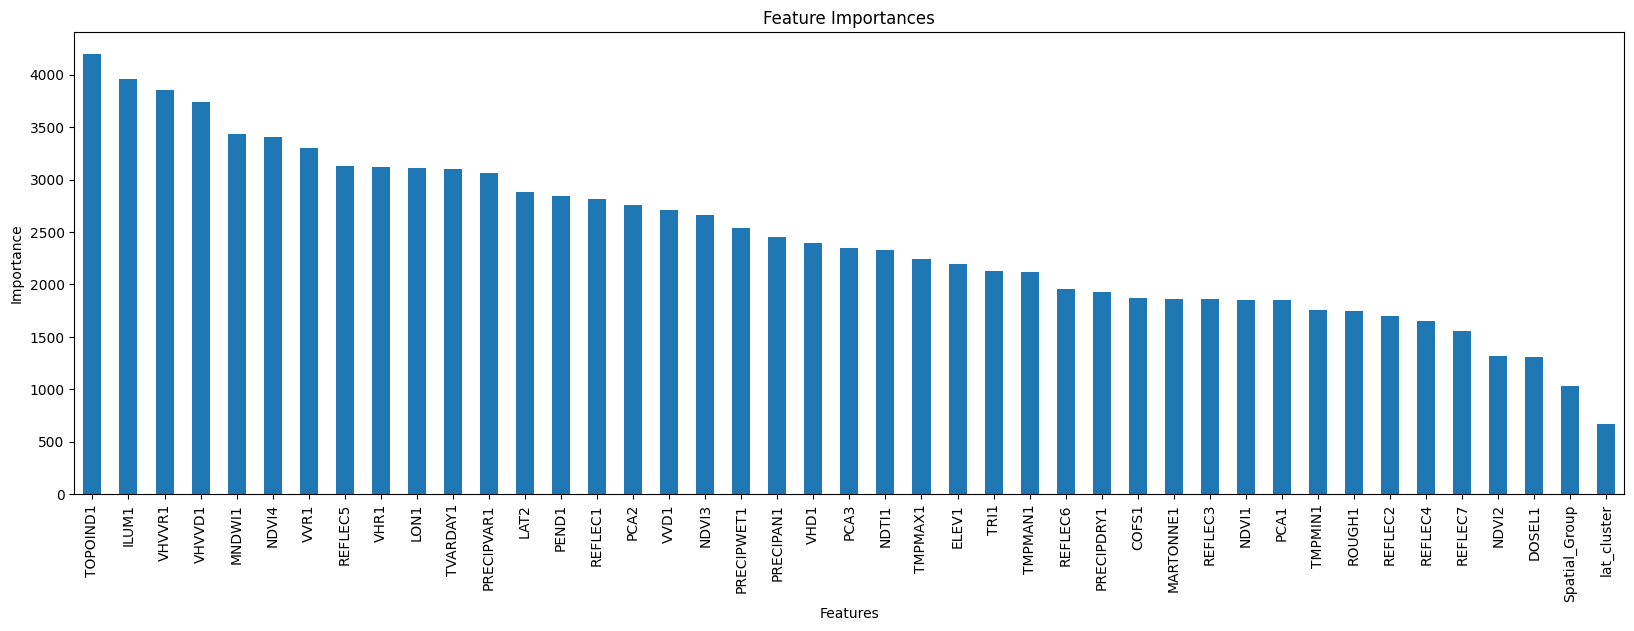

In [11]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(20, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()